In [56]:
#Librerias
import numpy as np
import pandas as pd
from cesium import featurize
import matplotlib.pyplot as plt
import seaborn

# generacion de datos

In [57]:
def generate_sine_dataset(
      n_series=10,
    t_min=0.0,
    t_max=50.0,
    min_length=150,
    max_length=200,
    freq_range=(0.1, 2.0),
    phase_range=(0.0, 2*np.pi),
    amp_range=(0.5, 5.0),
    noise_std=0.05,
    irregular_prob=0.001,
    sample_method='jitter',   # 'random' o 'jitter'
    jitter_scale=0.01,
    seed=643,
    target=0): 
    """
    Esta funcion genera dos df de Pandas, uno con las series y otro con metadatos.
      - df_long: DataFrame 'long' con columnas ['series_id', 't', 'value']
      - df_meta: DataFrame con metadatos por serie y la columna 'target' que indica la clase

    
    """
    rng = np.random.default_rng(seed)
    rows = []
    meta_rows = []

    for sid in range(n_series):
        length = int(rng.integers(min_length, max_length + 1))

        t_start = t_min
        t_end = float(rng.uniform(t_start, t_max))

        is_irregular = bool(rng.random() < irregular_prob)

        if is_irregular:
            if sample_method == 'random':
                t = np.sort(rng.uniform(t_start, t_end, size=length))
            elif sample_method == 'jitter':
                regular = np.linspace(t_start, t_end, length)
                scale = jitter_scale * (t_end - t_start) / max(1, length)
                t = regular + rng.normal(0, scale, size=length)
                t = np.clip(t, t_start, t_end)
                t = np.sort(t)
            else:
                raise ValueError("sample_method debe ser 'random' o 'jitter'")
        else:
            t = np.linspace(t_start, t_end, length)

        freq = float(rng.uniform(freq_range[0], freq_range[1]))
        phase = float(rng.uniform(phase_range[0], phase_range[1]))
        amp = float(rng.uniform(amp_range[0], amp_range[1]))

        noise = rng.normal(0, noise_std, size=length)
        values = amp * np.sin(2 * np.pi * freq * t + phase) + noise

        sid_str = f'series_{sid}'
        for ti, vi in zip(t, values):
            rows.append({
                'series_id': sid_str,
                't': float(ti),
                'value': float(vi)
            })

        meta_rows.append({
            'series_id': sid_str,
            'length': length,
            'amplitude': amp,
            'frequency': freq,
            'phase': phase,
            'is_irregular': is_irregular,
            'target': target
        })

    df_long = pd.DataFrame(rows, columns=['series_id', 't', 'value'])
    df_long['series_id'] = df_long['series_id'].astype(str)
    df_long['t'] = df_long['t'].astype(float)
    df_long['value'] = df_long['value'].astype(float)

    df_meta = pd.DataFrame(meta_rows, columns=['series_id', 'length', 'amplitude', 'frequency', 'phase', 'is_irregular', 'target'])
    df_meta['series_id'] = df_meta['series_id'].astype(str)
    df_meta['length'] = df_meta['length'].astype(int)
    df_meta['amplitude'] = df_meta['amplitude'].astype(float)
    df_meta['frequency'] = df_meta['frequency'].astype(float)
    df_meta['phase'] = df_meta['phase'].astype(float)
    df_meta['is_irregular'] = df_meta['is_irregular'].astype(bool)

    return df_long, df_meta



Generamos 4 clases de datos

In [58]:

runs = [
    {'freq_range': (0.1, 0.5),   'amp_range': (1.0, 2.0),  'target': 0},  # muy lentas
    {'freq_range': (0.6, 1.0),   'amp_range': (0.5, 1.5),  'target': 1},  # bajas
    {'freq_range': (1.5, 3.0),   'amp_range': (1.0, 3.0),  'target': 2},  # medias
    {'freq_range': (4.0, 7.0),   'amp_range': (0.8, 2.5),  'target': 3},  # medio-altas
    {'freq_range': (8.0, 12.0),  'amp_range': (1.0, 4.0),  'target': 4},  # altas
    {'freq_range': (15.0, 25.0), 'amp_range': (2.0, 5.0),  'target': 5},  # muy altas
    {'freq_range': (30.0, 50.0), 'amp_range': (1.0, 3.0),  'target': 6},  # ultra rápidas
]

# --- Parámetros generales ---
n_series_per_run = 200
next_series_id = 100

series_list = []
meta_list = []

# --- Bucle principal ---
for i, cfg in enumerate(runs, start=1):
    df_long, df_meta = generate_sine_dataset(
        n_series=n_series_per_run,
        freq_range=cfg['freq_range'],
        amp_range=cfg['amp_range'],
        seed=42 + i,
        target=cfg['target']
    )
    
    # mapping numérico único
    old_ids = df_meta['series_id'].unique().tolist()
    new_ids = list(range(next_series_id, next_series_id + len(old_ids)))
    mapping = dict(zip(old_ids, new_ids))
    
    df_long = df_long.copy()
    df_meta = df_meta.copy()
    df_long['series_id'] = df_long['series_id'].map(mapping).astype(int)
    df_meta['series_id'] = df_meta['series_id'].map(mapping).astype(int)
    
    next_series_id += len(old_ids)
    
    series_list.append(df_long[['series_id', 't', 'value']])
    meta_list.append(df_meta)

# --- Concatenar todo ---
df_all_series = pd.concat(series_list, ignore_index=True)
df_all_meta   = pd.concat(meta_list,   ignore_index=True)

# --- Comprobaciones ---
print("df_all_series.shape:", df_all_series.shape)
print("df_all_meta.shape:", df_all_meta.shape)
print("Series únicos:", df_all_meta['series_id'].nunique())
print("Clases (targets):", df_all_meta['target'].unique())

print(df_all_meta.groupby('target')[['frequency', 'amplitude']].agg(['min','max']).round(2))


# listas para acumular resultados
series_list = []
meta_list = []

# number of series por llamada (ajusta si quieres)
n_series_per_run = 200

# contador de ID numérico único (comienza en 100)
next_series_id = 100

# bucle: llamar la función 4 veces
for i, cfg in enumerate(runs, start=1):
    # llama a tu función; usa seed distinto si quieres variabilidad
    df_long, df_meta = generate_sine_dataset(
        n_series=n_series_per_run,
        freq_range=cfg['freq_range'],
        seed=42 + i,          # opcional: cambiar seed por run
        target=cfg['target']
    )
    
    # crear mapping numérico para los series_id de este run
    old_ids = df_meta['series_id'].unique().tolist()  # ej. ['series_0', 'series_1', ...]
    new_ids = list(range(next_series_id, next_series_id + len(old_ids)))
    mapping = dict(zip(old_ids, new_ids))
    
    # aplicar mapping tanto en df_long como en df_meta
    df_long = df_long.copy()
    df_meta = df_meta.copy()
    df_long['series_id'] = df_long['series_id'].map(mapping).astype(int)
    df_meta['series_id'] = df_meta['series_id'].map(mapping).astype(int)
    
    # actualizar el contador para la siguiente iteración
    next_series_id += len(old_ids)
    
    # añadir a las listas
    series_list.append(df_long[['series_id', 't', 'value']])
    meta_list.append(df_meta)  # df_meta ya contiene 'target'
    
# concatenar todo en dos DataFrames finales
df_all_series = pd.concat(series_list, ignore_index=True)
df_all_meta   = pd.concat(meta_list,   ignore_index=True)

#comprobaciones rápidas
print("df_all_series.shape:", df_all_series.shape)
print("df_all_meta.shape:", df_all_meta.shape)
print("series únicos en meta:", df_all_meta['series_id'].nunique())
print("min/max series_id en meta:", df_all_meta['series_id'].min(), df_all_meta['series_id'].max())

# ver primeras filas
print(df_all_series.head())
print(df_all_meta.head())


df_all_series.shape: (245355, 3)
df_all_meta.shape: (1400, 7)
Series únicos: 1400
Clases (targets): [0 1 2 3 4 5 6]
       frequency        amplitude      
             min    max       min   max
target                                 
0           0.10   0.50      1.00  1.96
1           0.60   1.00      0.50  1.49
2           1.50   3.00      1.03  3.00
3           4.01   6.99      0.80  2.50
4           8.04  11.99      1.04  3.99
5          15.03  24.98      2.04  4.99
6          30.04  49.98      1.01  2.99
df_all_series.shape: (245355, 3)
df_all_meta.shape: (1400, 7)
series únicos en meta: 1400
min/max series_id en meta: 100 1499
   series_id         t     value
0        100  0.000000 -0.785861
1        100  0.012579 -0.820363
2        100  0.025158 -0.912799
3        100  0.037737 -0.854229
4        100  0.050316 -0.909242
   series_id  length  amplitude  frequency     phase  is_irregular  target
0        100     175   1.511174   0.435685  3.689129         False       0
1        1

# Extraccion de Features

In [59]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

def extract_features_byCesium(df_all_series,
                              features_to_use=features_to_use,
                              min_points_per_serie=5):

    full_object_list = sorted(df_all_series['series_id'].unique())

    grouped = df_all_series.groupby('series_id')

    time_list = []
    value_list = []
    object_list = []

    for obj_id,g in grouped:
        g = g.sort_values('t')
        if len(g) < min_points_per_serie:
            print(f"Skipping series_id {obj_id} with only {len(g)} points")
            continue

        time_list.append(g['t'].values)
        value_list.append(g['value'].values)
        object_list.append(obj_id)

    if len(object_list) == 0:
        raise ValueError("No series with enough points found.")
    
    ds = featurize.featurize_time_series(times=time_list,
                                         values=value_list,
                                         features_to_use=features_to_use,
                                         scheduler='threads'
                                         )

    if len(ds) == len(object_list):
        ds.index = object_list

    #ds = ds.reset_index().rename(columns={'index': 'object_id'})
            
    
    return ds


In [60]:
#Generamos un df con las features
df_features = extract_features_byCesium(df_all_series,
                                        features_to_use=features_to_use,
                                        min_points_per_serie=5)

In [61]:
#comprobaciones rápidas
print(df_features.shape)
print(df_features.head())
print(df_features.describe())
print(df_features.index)
print(df_features.columns)

(1400, 11)
feature amplitude percent_beyond_1_std   maximum   max_slope    median  \
channel         0                    0         0           0         0   
100      1.596155             0.497143  1.590655   16.605175  0.085947   
101      0.178719             0.322404  1.180643  108.888787  1.011955   
102      1.405199             0.503268  1.410933    4.086714 -0.082726   
103      2.676949             0.515152  2.646269    8.415501 -0.542010   
104      4.867969             0.506667  4.868453   16.866570 -0.242390   

feature median_absolute_deviation percent_close_to_median   minimum      skew  \
channel                         0                       0         0         0   
100                      1.106650                0.131429 -1.601654 -0.070015   
101                      0.046506                0.387978  0.823205 -0.238352   
102                      0.941724                0.150327 -1.399465  0.012251   
103                      1.902019                0.121212 -2.7076

In [62]:
#pasemoslo a .csv
df_features.to_csv("features.csv")

# Gausian Mixture Models

In [63]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

In [64]:
#Por robustez, reemplazamos NaNs por la mediana de cada feature
feats_imputed = df_features.fillna(df_features.median())
# Normalizamos las features
scaler = StandardScaler()
X = scaler.fit_transform(feats_imputed.values)
print(X.shape)

(1400, 11)


En GMM usamos pca, si embargo, lo probé sin PCA y no hay diferencias notables

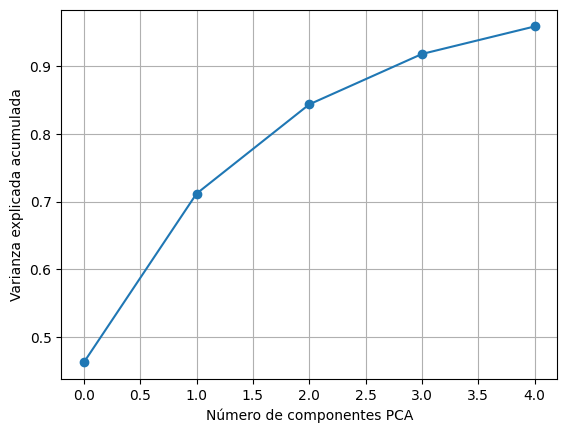

In [65]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=42) #Svd_solver = 'full' es el que mejor resultado da
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

In [66]:
# Entrenamiento Gaussian Mixture Model (GMM)
# Probamos con 4 clusters, ya que sabemos que hay 4 clases
n_clusters = 7
gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, n_init=10)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

In [67]:
label_df = pd.DataFrame({'series_id': feats_imputed.index.astype(int), 'gmm_label': labels})
print(label_df.head())
label_df.to_csv("gmm_labels.csv", index=False)

   series_id  gmm_label
0        100          1
1        101          3
2        102          1
3        103          6
4        104          6


In [68]:
#Generamos otro df con las clases predichas
df_all_meta_with_predictions = df_all_meta.copy()
df_all_meta_with_predictions = df_all_meta_with_predictions.merge(label_df, on='series_id', how='left')
print(df_all_meta_with_predictions.head())

   series_id  length  amplitude  frequency     phase  is_irregular  target  \
0        100     175   1.511174   0.435685  3.689129         False       0   
1        101     183   1.138155   0.146333  0.926919         False       0   
2        102     153   1.322354   0.395460  5.055675         False       0   
3        103     165   2.606931   0.174363  4.319495         False       0   
4        104     150   4.758688   0.481758  2.135353         False       0   

   gmm_label  
0          1  
1          3  
2          1  
3          6  
4          6  


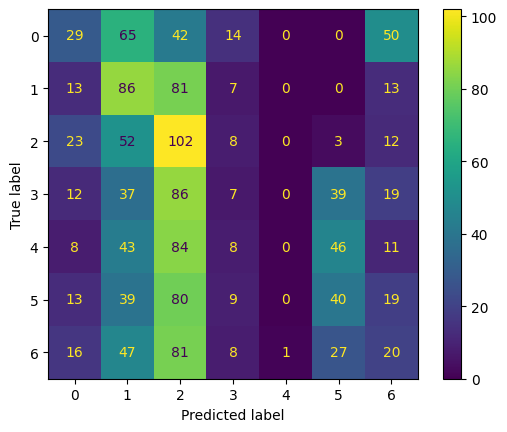

In [69]:
#Veamos la matriz de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
true = df_all_meta_with_predictions['target'].to_numpy()
pred = df_all_meta_with_predictions['gmm_label'].to_numpy()
cm = confusion_matrix(true, pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


# Random forest

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [71]:
#Sin PCA
y = df_all_meta['target'].to_numpy()
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=500,       
    max_depth=None,         
    random_state=42,
    n_jobs=-1               
)

rf.fit(X_train, y_train)

(1400, 11)


,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy: 0.38571428571428573

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.93      0.70        40
           1       0.45      0.65      0.53        40
           2       0.51      0.50      0.51        40
           3       0.18      0.15      0.16        40
           4       0.24      0.17      0.20        40
           5       0.33      0.20      0.25        40
           6       0.13      0.10      0.11        40

    accuracy                           0.39       280
   macro avg       0.34      0.39      0.35       280
weighted avg       0.34      0.39      0.35       280


Confusion matrix:


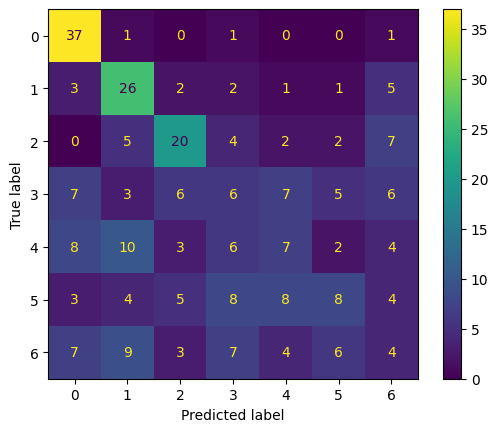

In [72]:
# Predicciones
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)  # probabilidades por clase

# Métricas
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


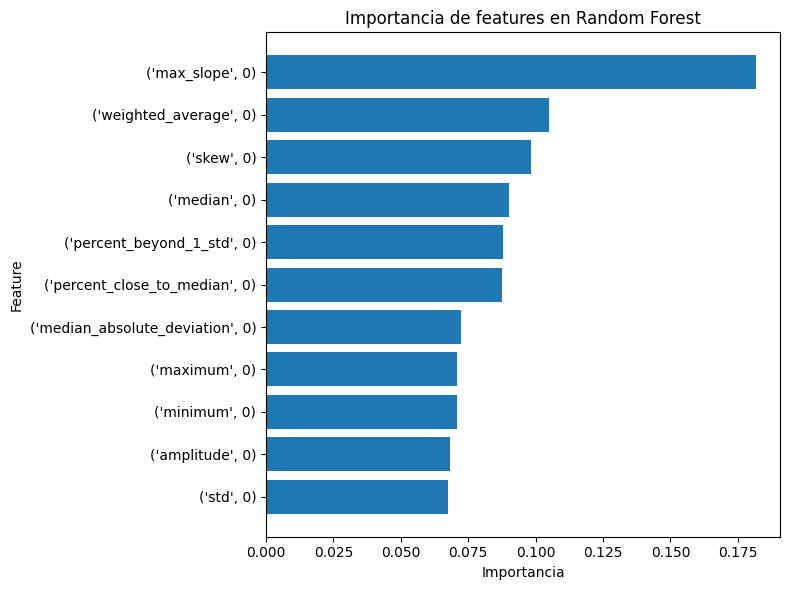

In [73]:
# Obtener importancias y nombres
importances = rf.feature_importances_
feature_names = feats_imputed.columns

# Ordenar de mayor a menor importancia
indices = np.argsort(importances)[::-1]

# Reordenar según la importancia
sorted_importances = importances[indices]
sorted_features = feature_names[indices]

# Gráfico de barras horizontal
plt.figure(figsize=(8, max(6, len(sorted_features) * 0.4)))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features, fontsize=10)
plt.gca().invert_yaxis()  # La más importante arriba
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de features en Random Forest")
plt.tight_layout()
plt.show()


In [74]:
#Usamos X con pca del apartado anterior
X1 = X_pca
y = df_all_meta['target'].to_numpy()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=500,       
    max_depth=None,         
    random_state=42,
    n_jobs=-1               
)

rf.fit(X_train1, y_train1)


,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy: 0.25357142857142856

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.57      0.46        40
           1       0.23      0.23      0.23        40
           2       0.24      0.23      0.23        40
           3       0.22      0.20      0.21        40
           4       0.28      0.25      0.26        40
           5       0.20      0.17      0.19        40
           6       0.14      0.12      0.13        40

    accuracy                           0.25       280
   macro avg       0.24      0.25      0.24       280
weighted avg       0.24      0.25      0.24       280


Confusion matrix:


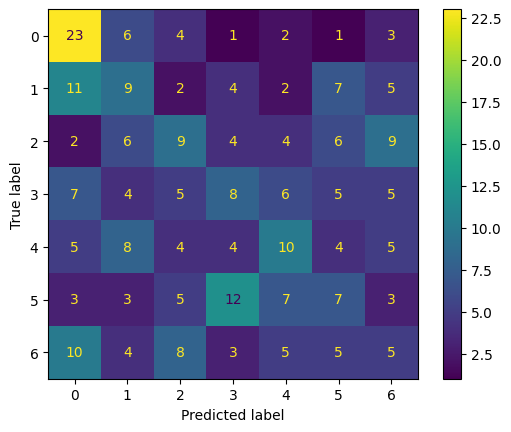

In [75]:
# Predicciones
y_pred1 = rf.predict(X_test1)
y_proba1 = rf.predict_proba(X_test1)  # probabilidades por clase

# Métricas
acc = accuracy_score(y_test1, y_pred1)
print("Accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test1, y_pred1))

print("\nConfusion matrix:")
cm = confusion_matrix(y_test1, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



# MLP

In [76]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import random

In [77]:
train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train)
)

test_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test)
)

In [78]:
print(X_train.shape[1])

11


In [79]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size):
       
        super().__init__()

        
        self.mlp_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, 4)            
        )

    def forward(self, x):
        return self.mlp_net(x)

In [80]:
#Early Stopping
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [ ]:
import time

def NN_classifier(model, train_dataset, val_dataset, epochs, criterion, batch_size, lr, early_stopping_tolerance=15, use_GPU=False):
    
    if use_GPU:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    #dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    #optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{epochs} - Batch {i}/{len(train_loader)}", end="")
            if use_GPU:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            y_batch = y_batch.long().squeeze()

            # Cálculo de loss
            if torch.any(y_batch >= y_predicted.shape[1]):
                print("Etiqueta fuera de rango detectada!")
                print("Máx label:", y_batch.max().item())
                print("Num clases (salida):", y_predicted.shape[1])
                raise ValueError("Hay etiquetas con valores fuera del rango válido.")
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

            preds = y_predicted.argmax(dim=1)  
            cumulative_train_corrects += (y_batch == preds).sum()

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects / len(train_dataset)

        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))

        if use_GPU:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        y_val = y_val.long().squeeze()
        loss = criterion(y_predicted, y_val)

        class_prediction = y_predicted.argmax(dim=1) 
        val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
        val_loss = loss.item()

        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    from sklearn.metrics import (
            classification_report,
            accuracy_score,
            precision_score,
            recall_score,
            f1_score,
            precision_recall_fscore_support
        )
        

    #Imprimir métricas
    try:
        y_true_np = y_val.detach().cpu().numpy().astype(int).ravel()
    except:
        y_true_np = y_val.cpu().numpy().astype(int).ravel()
    try:
        y_pred_np = class_prediction.detach().cpu().numpy().astype(int).ravel()
    except:
        y_pred_np = class_prediction.cpu().numpy().astype(int).ravel()
    # Accuracy
    acc = float(accuracy_score(y_true_np, y_pred_np))
    # Precision/Recall/F1: micro, macro, weighted
    p_macro = float(precision_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    p_micro = float(precision_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    p_weighted = float(precision_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    r_macro = float(recall_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    r_micro = float(recall_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    r_weighted = float(recall_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    f1_macro = float(f1_score(y_true_np, y_pred_np, average="macro", zero_division=0))
    f1_micro = float(f1_score(y_true_np, y_pred_np, average="micro", zero_division=0))
    f1_weighted = float(f1_score(y_true_np, y_pred_np, average="weighted", zero_division=0))
    # Per-class metrics (precision, recall, f1, support)
    
    if y_true_np.size == 0:
        labels = []
    else:
        max_label = int(max(y_true_np.max() if y_true_np.size>0 else 0, y_pred_np.max() if y_pred_np.size>0 else 0))
        labels = list(range(max_label + 1))
    perclass = precision_recall_fscore_support(y_true_np, y_pred_np, labels=labels, zero_division=0)
    per_precisions = perclass[0]
    per_recalls = perclass[1]
    per_f1s = perclass[2]
    per_support = perclass[3]
    # Imprimir resumen compacto
    print("\nValidation metrics summary:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision -> macro: {p_macro:.4f}, micro: {p_micro:.4f}, weighted: {p_weighted:.4f}")
    print(f"  Recall    -> macro: {r_macro:.4f}, micro: {r_micro:.4f}, weighted: {r_weighted:.4f}")
    print(f"  F1-score  -> macro: {f1_macro:.4f}, micro: {f1_micro:.4f}, weighted: {f1_weighted:.4f}")
    # Imprimir tabla por clase
    if len(labels) > 0:
        print("\nPer-class metrics:")
        print("{:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1"))
        for idx, lab in enumerate(labels):
            print("{:>10} {:10.4f} {:10.4f} {:10.4f} (support={})".format(
                str(lab), float(per_precisions[idx]), float(per_recalls[idx]), float(per_f1s[idx]), int(per_support[idx])
            ))
    
    try:
        report = classification_report(y_true_np, y_pred_np, zero_division=0)
        print("\nClassification report (validation):\n", report)
    except Exception as e:
        print("No se pudo generar classification_report:", e)
        
    model.cpu()

    return curves


In [83]:
epochs = 100
lr = 1e-3
batch_size = 32
early_stopping_tolerance = 15
use_gpu = True 

criterion = nn.CrossEntropyLoss()

input_size = X_train.shape[1]
hidden_size = 10
model = MLPModel(input_size, hidden_size=hidden_size)

curves = NN_classifier(model, train_dataset, test_dataset, epochs, criterion, batch_size, lr, early_stopping_tolerance, use_gpu)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


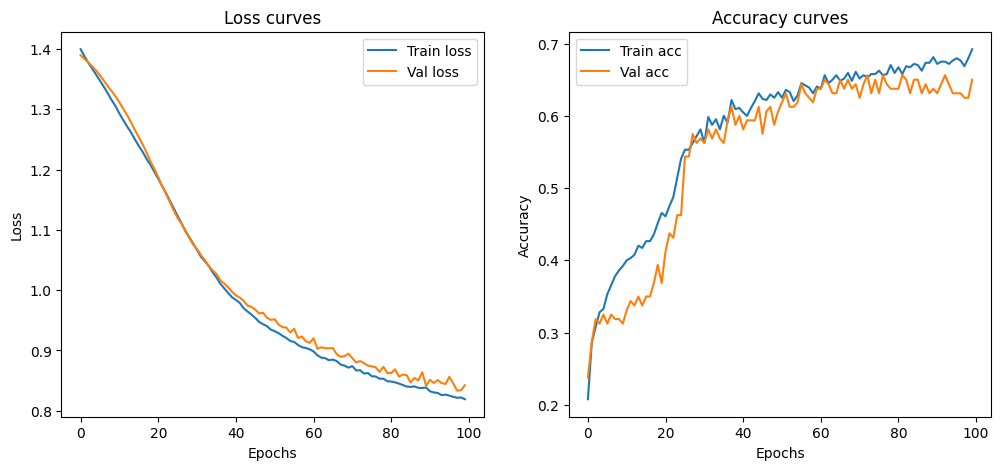

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(curves["train_loss"], label="Train loss")
plt.plot(curves["val_loss"], label="Val loss")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves["train_acc"], label="Train acc")
plt.plot(curves["val_acc"], label="Val acc")
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
def plot_cm(model, dataset, batch_size=128, class_names=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # loader
    if isinstance(dataset, torch.utils.data.DataLoader):
        loader = dataset
    else:
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    model.eval()

    y_trues, y_preds = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)                    
            preds = outputs.argmax(dim=1).cpu().numpy()

            
            if y.dim() == 2 and y.size(1) > 1:
                y = y.argmax(dim=1)
            y = y.cpu().numpy()

            y_trues.append(y)
            y_preds.append(preds)

    y_true = np.concatenate(y_trues, axis=0)
    y_pred = np.concatenate(y_preds, axis=0)

    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=(class_names if class_names is not None else None))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, values_format='d', cmap='viridis')  
    plt.title("Matriz de confusión")
    plt.show()

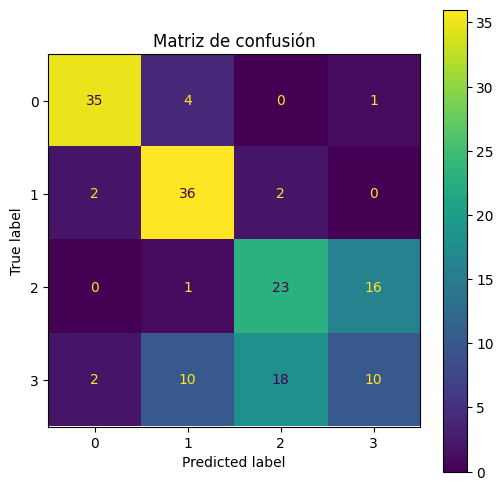

In [ ]:
#Matriz de confusión
cm = plot_cm(model, test_dataset, batch_size=32, class_names=['0','1','2','3'], device='cuda' if use_gpu else 'cpu')


# CNN

In [ ]:
class CNNFeatures(nn.Module):
   
    def __init__(self,
                 n_features,
                 n_classes,
                 in_channels=1,
                 channels=(16, 32),
                 kernel_sizes=(3, 3),
                 pool_kernel=2,
                 dropout=0.2):
        super().__init__()
        assert len(channels) == len(kernel_sizes), "channels y kernel_sizes deben tener el mismo largo"
        self.n_features = n_features

        
        self.in_channels = in_channels

        blocks = []
        curr_in = in_channels
        for out_ch, k in zip(channels, kernel_sizes):
          
            padding = k // 2
            blocks += [
                nn.Conv1d(curr_in, out_ch, kernel_size=k, padding=padding),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=pool_kernel, stride=pool_kernel)
            ]
            curr_in = out_ch

        self.encoder = nn.Sequential(*blocks)

        
        self.global_pool = nn.AdaptiveAvgPool1d(1)  

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Flatten(),               
            nn.Dropout(dropout),
            nn.Linear(curr_in, n_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        
        if x.dim() == 2:
            
            x = x.unsqueeze(1)
        else:
            
            pass

        
        x = self.encoder(x)          
        x = self.global_pool(x)      
        out = self.classifier(x)     
        return out


In [ ]:
n_features = 11
n_classes = 4

model = CNNFeatures(n_features=n_features,
                    n_classes=n_classes,
                    in_channels=1,            
                    channels=(16, 32),        
                    kernel_sizes=(5, 3),
                    pool_kernel=2,
                    dropout=0)

criterion = torch.nn.CrossEntropyLoss()
curves = NN_classifier(model, train_dataset, test_dataset,
                        epochs=150,
                        criterion=criterion,
                        batch_size=16,
                        lr=1e-3,
                        early_stopping_tolerance=15,
                        use_GPU=True)   


Epoch 1/150 - Batch 39/40 - Train loss: 1.5506813287734986, Train acc: 0.24375000596046448, Val loss: 1.3757882118225098, Val acc: 0.29375001788139343
Epoch 2/150 - Batch 39/40 - Train loss: 1.3226306170225144, Train acc: 0.3765625059604645, Val loss: 1.3213940858840942, Val acc: 0.3125
Epoch 3/150 - Batch 39/40 - Train loss: 1.2901147097349166, Train acc: 0.3812499940395355, Val loss: 1.3012348413467407, Val acc: 0.35625001788139343
Epoch 4/150 - Batch 39/40 - Train loss: 1.2766264170408248, Train acc: 0.42656251788139343, Val loss: 1.287360429763794, Val acc: 0.4124999940395355
Epoch 5/150 - Batch 39/40 - Train loss: 1.2545682936906815, Train acc: 0.40625, Val loss: 1.2845662832260132, Val acc: 0.375
Epoch 6/150 - Batch 39/40 - Train loss: 1.2412517562508583, Train acc: 0.4046874940395355, Val loss: 1.268545389175415, Val acc: 0.4124999940395355
Epoch 7/150 - Batch 39/40 - Train loss: 1.2240110963582993, Train acc: 0.4593749940395355, Val loss: 1.2549118995666504, Val acc: 0.36875000

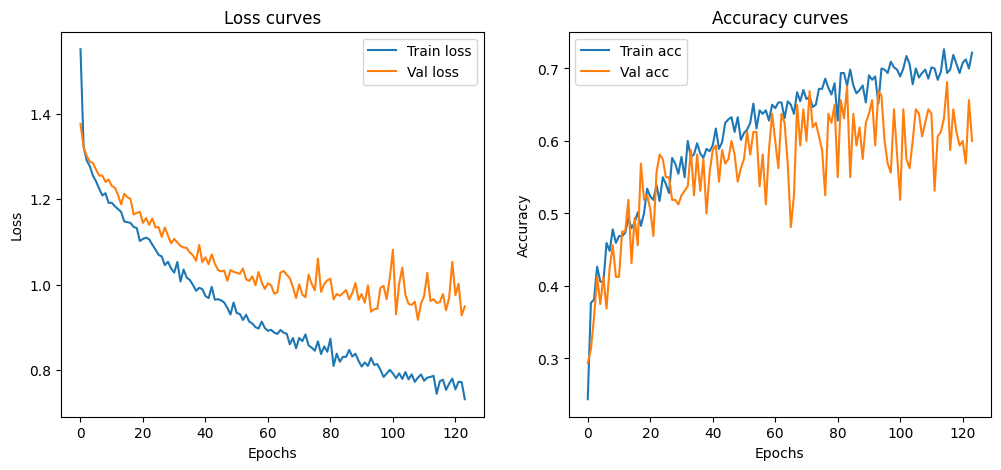

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(curves["train_loss"], label="Train loss")
plt.plot(curves["val_loss"], label="Val loss")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(curves["train_acc"], label="Train acc")
plt.plot(curves["val_acc"], label="Val acc")
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

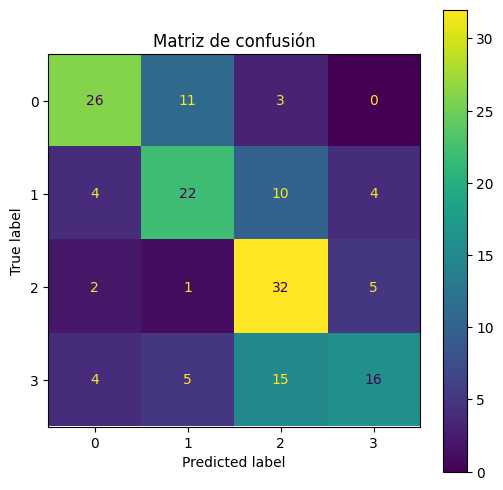

In [ ]:
#Matriz de confusión
cm = plot_cm(model, test_dataset, batch_size=32, class_names=['0','1','2','3'], device='cuda' if use_gpu else 'cpu')